# FIT5196 Assessment 3

#### Student Name: PRASHANT JAJORIA
#### Student ID: 31187366

Date: 18/11/2020

Environment: Python 3.7.4 and Anaconda 4.8.4 (64-bit)

Libraries used:
1. **xmltodict** - for convertigng the XML data to a dictionary object, additional python package used for this task.
2. **pandas** - for reading and writing CSV file, and manipulating Datafarme, included in Anaconda Python 3.7.4
3. **json** - for reading JSON data format and storing as a dictionary, included in Anaconda Python 3.7.4
4. **tabula** - for reading data stored in PDF files, additional python package used for this task.
5. **re** - for regular expression, included in Anaconda Python 3.7.4
6. **math** - for carrying out operations like pow,sin, cos, log, sqrt and radians, included in Anaconda Python 3.7.4
7. **shapefile** - for reading shape file data format, additional python package used for this task.
8. **shapely.geometry** - for plotting geometrical objects and shapes, additional python package used for this task.
9. **datetime** - for validating date, included in Anaconda Python 3.7.4
10. **matplotlib** - for visualizing data, included in Anaconda Python 3.7.4
11. **numpy** - for arithmetic operations and calculations on arrays, included in Anaconda Python 3.7.4
12. **bs4** - for reading the html files, additional python package used for this task.
13. **codecs** - for defining the codec of files, included in Anaconda Python 3.7.4
14. **sklearn** - for carrying out transformations like zscore.

## Introduction
The main goal of this assessment is Integrating data of different file formats to merge and combine them to make it easy readible. This merged data is used for different calculations to predict the values of other columns. Also, a number of different transformations and scaling techniques are carried out to make the data easily readible for Linear regression model.

Following are the requirement of the task:
1. Read and store data of different file formats.
2. Integrate and merge data from different file formats.
3. Carry out calculations to predict the values of other columns.
4. Data scaling to remove the scales of different variables.
5. Carry out different transformations to remove the skewness of data.
6. Handling shape files to make points and polygons.

A step by step explanation of completing the requirements will be explained in the following code cells.

# Task 1 : Data Integration

## Import libraries

In [1]:
import xmltodict
import pandas as pd
import json
import tabula
import re
import math
import shapefile
from shapely.geometry import shape, Point
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import codecs
from sklearn import preprocessing

## Reading XML

Reading the data from .xml file. The XML is not in correct format. So it is first cleaned and then converted to dictionary using `xmltodict` package.

In [2]:
file_read_state_xml = open("real_state.xml", "r")
str_file_read_state_xml = file_read_state_xml.read()

# trim the file
str_file_read_state_xml = str_file_read_state_xml[2:len(str_file_read_state_xml)-1]

In [3]:
dict_real_state_xml = xmltodict.parse(str_file_read_state_xml)

Make a dataframe to store all the values of the properties, hospitals, supermarkets, shopping centres and train stations.

In [4]:
lst_columns = ["property_id","lat","lng","addr_street","price","property_type","year","bedrooms","bathrooms","parking_space"]

df = pd.DataFrame(index=range(1003), columns=lst_columns)

for col in lst_columns:
    lst_data = []
    
    for node in dict_real_state_xml['root'][col]:
        if type(dict_real_state_xml['root'][col][node]) != str:
            lst_data.append(list(dict_real_state_xml['root'][col][node].items())[1][1])
    df[col] = lst_data

## Reading JSON

Reading the real estate data from the JSON file and apending to the existing dataframe

In [5]:
## read json
with open("real_state.json") as f:
  data = json.load(f)

In [6]:
for n in range(1010):
    dict_property = {}
    
    for col in lst_columns:
        dict_property[col] = data[n][col]
    
    df = df.append(dict_property,True)

## Drop duplicate rows

There are 5 rows which are completely duplicated. We drop those rows to remove redundant data.

In [7]:
df[df.duplicated()].shape

(5, 10)

In [8]:
df.drop_duplicates(keep="first",inplace=True)
df.reset_index(drop=True, inplace=True)

There are 29 rows where the properties have the same address. Removing those redundant rows.

In [9]:
df[df.duplicated(['addr_street'])].shape

(29, 10)

In [10]:
df.drop_duplicates(subset=['addr_street'],keep="first",inplace=True)
df.reset_index(drop=True, inplace=True)

## Reading PDF file - Shopping Centre

To read the data of shoping centres from the PDF file, I used `tabula` pacakage. The `read_pdf` function reads all the pages of the file and the tables, storing the data in a dataframe.

In [11]:
tables = tabula.read_pdf("shopingcenters.pdf", pages = "all", multiple_tables = True)

In [12]:
df_shopping_centres = tables[0]
df_shopping_centres = df_shopping_centres.append([tables[1],tables[2]],True)

In [13]:
## drop the first column
df_shopping_centres.drop(["Unnamed: 0"],inplace=True,axis=1)

In [14]:
## make the shopping centre id as index
df_shopping_centres.index = df_shopping_centres['sc_id']
df_shopping_centres.drop(["sc_id"],axis=1,inplace=True)

## Havershine

Using the havershine formula to calculate the distance between the real estate and the shoping centres, hospitals, supermarkets and train stations.

In [15]:
'''
Calculate distance using the Haversine Formula.

Reference:
https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula
'''

def haversine(coord1: object, coord2: object):

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6378000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 3)
    km = round(km, 4)

    return meters

In [16]:
# prepare the data in Lat,Long form
loc = df[['lat', 'lng']].apply(lambda x: ','.join(x.astype(str)), axis = 1)

# df - property lat, long
df_loc = pd.DataFrame(index = range(len(loc)), data = loc, columns = ['property_lat_long'])

Defining a function to calculate the distance of real estate from all the shopping centres 

In [17]:
def cal_sc_dist(lat_long):
    
    # property location
    lat_long = str(lat_long)
    re_results = re.findall(r'(-?\d+\.-?\d+)',lat_long)
    
    #print(re_results)
    
    prop_lat = float(re_results[0])
    prop_long = float(re_results[1])
    
    dict_distance_from_sc = {}
    
    # calculate the distance from each of the shopping centres
    for shopping_centre, location in df_shopping_centres.to_dict('index').items():
        
        # haversine() function needs 2 list containing Lat, Long   
        distance_from_sc = haversine([location['lat'],location['lng']], [prop_lat,prop_long])
        
        # store results in a dict
        dict_distance_from_sc[shopping_centre] = distance_from_sc
        
    #print(dict_distance_from_sc)
    return dict_distance_from_sc

Defining a function to get the data of the nearest shopping centres.

In [18]:
def get_nearest_sc(dict_distance_from_sc):
    
    # get the min distance
    min_dist = min(dict_distance_from_sc.values())
    
    # get the id of shopping centre corresponding to min distance
    nearest_sc = [ sc for sc, distance in dict_distance_from_sc.items() if distance == min_dist ]
    
    dict_nearest_sc = {}
    
    # dict of nearest sc name and distance
    dict_nearest_sc[nearest_sc[0]] = min_dist
    
    return dict_nearest_sc

Defining a function to get the distance of the real estate from the nearest shopping centres.

In [19]:
def get_nearest_sc_dist(dict_nearest_sc):
    return round(list(dict_nearest_sc.values())[0])

Defining a function to get the id of the nearest shopping centre from the real estate. 

In [20]:
def get_nearest_sc_id(dict_nearest_sc):
    return list(dict_nearest_sc.keys())[0]

Storing the closest shopping centre and the distance in the dataframe

In [21]:
df['distance_to_sc'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_sc_dist(get_nearest_sc(cal_sc_dist(x))))
df['shopping_center_id'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_sc_id(get_nearest_sc(cal_sc_dist(x))))

## Train station - stops.txt

Reading the data of train stations from `stops.txt` and storing in a dataframe.

In [22]:
df_train_station = pd.read_csv("stops.txt")

In [23]:
df_train_station.index = df_train_station['stop_id']

Defining a function to calculate the distance of real estate from all the train stations.

In [24]:
def cal_train_station_dist(lat_long):
    
    # property location
    lat_long = str(lat_long)
    re_results = re.findall(r'(-?\d+\.-?\d+)',lat_long)
    
    prop_lat = float(re_results[0])
    prop_long = float(re_results[1])
    
    dict_distance_from_train_station = {}
    
    # calculate the distance from each of the Train station
    for train_station_id, train_station_details in df_train_station.to_dict('index').items():
        
        # haversine() function needs 2 list containing Lat, Long   
        distance_from_train_station = haversine([train_station_details['stop_lat'],train_station_details['stop_lon']], [prop_lat,prop_long])
        
        # store results in a dict
        dict_distance_from_train_station[train_station_id] = distance_from_train_station
        
    #print(dict_distance_from_train_station)
    return dict_distance_from_train_station

Defining a function to get the data of the nearest train station.

In [25]:
def get_nearest_train_station(dict_distance_from_train_station):
    
    # get the min distance
    min_dist = min(dict_distance_from_train_station.values())
    
    # get the id of train station corresponding to min distance
    nearest_train_station = [ train_st_id for train_st_id, distance in dict_distance_from_train_station.items() if distance == min_dist ]
    
    dict_nearest_train_st = {}
    
    # dict of nearest sc name and distance
    dict_nearest_train_st[nearest_train_station[0]] = min_dist
    
    return dict_nearest_train_st

Defining a function to get the distance of the real estate from the nearest train station

In [26]:
def get_nearest_train_station_dist(dict_distance_from_train_station):
    return round(list(dict_distance_from_train_station.values())[0])

Defining a function to get the id of the nearest train station from the real estate. 

In [27]:
def get_nearest_train_station_id(dict_distance_from_train_station):
    return list(dict_distance_from_train_station.keys())[0]

Storing the closest train station  from the real estate and the distance in the dataframe

In [28]:
df['train_station_id'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_train_station_id(get_nearest_train_station(cal_train_station_dist(x))))
df['distance_to_train_station'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_train_station_dist(get_nearest_train_station(cal_train_station_dist(x))))

## Hospitals - CSV

Reading the data of hospitals from the excel file and storing it in a dataframe

In [29]:
df_hospitals = pd.read_excel('hospitals.xlsx')
df_hospitals.index = df_hospitals['id']
df_hospitals.drop(['Unnamed: 0','id'],axis=1,inplace=True)

Defining a function to calculate the distance of real estate from all the hospitals.

In [30]:
def cal_hospital_dist(lat_long):
    
    # property location
    lat_long = str(lat_long)
    re_results = re.findall(r'(-?\d+\.-?\d+)',lat_long)
    
    prop_lat = float(re_results[0])
    prop_long = float(re_results[1])
    
    dict_distance_from_hospitals = {}
    
    # calculate the distance from each of the Hospitals
    for hospital_id, hospital_details in df_hospitals.to_dict('index').items():
        
        # haversine() function needs 2 list containing Lat, Long   
        distance_from_hospital = haversine([hospital_details['lat'],hospital_details['lng']], [prop_lat,prop_long])
        
        # store results in a dict
        dict_distance_from_hospitals[hospital_id] = distance_from_hospital
        
    #print(dict_distance_from_train_station)
    return dict_distance_from_hospitals

Defining a function to get the data of the nearest hospital for a property.

In [31]:
def get_nearest_hospital(dict_distance_from_hospitals):
    
    # get the min distance
    min_dist = min(dict_distance_from_hospitals.values())
    
    # get the id of train station corresponding to min distance
    nearest_hospital_id = [ hospital_id for hospital_id, distance in dict_distance_from_hospitals.items() if distance == min_dist ]
    
    dict_nearest_hopsital = {}
    
    # dict of nearest hospital name and distance
    dict_nearest_hopsital[nearest_hospital_id[0]] = min_dist
    
    return dict_nearest_hopsital

Defining a function to get the distance of the nearest hospital for a property.

In [32]:
def get_nearest_hospital_dist(dict_nearest_hopsital):
    return list(dict_nearest_hopsital.values())[0]

Defining a function to get the ID of the nearest hospital for a property.

In [33]:
def get_nearest_hospital_id(dict_nearest_hopsital):
    return list(dict_nearest_hopsital.keys())[0]

In [34]:
df['hospital_id'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_hospital_id(get_nearest_hospital(cal_hospital_dist(x))))
df['distance_to_hospital'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_hospital_dist(get_nearest_hospital(cal_hospital_dist(x))))

# Supermarkets.html

Reading the supermarkets data from the `html` file using the `codecs` and `BeautifulSoup` package

In [35]:
file = codecs.open("supermarkets.html", "r", "utf-8")
soup = BeautifulSoup(file.read(), 'lxml')

Extracting the data from each of the table row of the HTML

In [36]:
lst_supermarket_ids = []
lst_supermarket_lat = []
lst_supermarket_lng = []
lst_supermarket_type = []

for tag in soup.find_all('tr'):
    x = tag.find_all('td')
    
    if len(x) > 1:
        lst_supermarket_ids.append(x[0].text)
        lst_supermarket_lat.append(x[1].text)
        lst_supermarket_lng.append(x[2].text)
        lst_supermarket_type.append(x[3].text)

Storing the data of supermarket in a dataframe

In [37]:
df_supermarkets = pd.DataFrame(index=range(len(lst_supermarket_ids)), columns=['supermarket_id','supermarket_lat','supermarket_lng','supermarket_type'])

In [38]:
df_supermarkets['supermarket_id'] = lst_supermarket_ids
df_supermarkets['supermarket_lat'] = lst_supermarket_lat
df_supermarkets['supermarket_lng'] = lst_supermarket_lng
df_supermarkets['supermarket_type'] = lst_supermarket_type

In [39]:
df_supermarkets.index = df_supermarkets['supermarket_id']
df_supermarkets.drop(['supermarket_id'],axis=1,inplace=True)

Defining a function to calculate the distance of real estate from all the supermarkets.

In [40]:
def cal_supermarkets_dist(lat_long):
    
    # property location
    lat_long = str(lat_long)
    re_results = re.findall(r'(-?\d+\.-?\d+)',lat_long)
    
    prop_lat = float(re_results[0])
    prop_long = float(re_results[1])
    
    dict_distance_from_supermarkets = {}
    
    # calculate the distance from each of the Supermarkets
    for supermarkets_id, supermarkets_details in df_supermarkets.to_dict('index').items():
        
        # haversine() function needs 2 list containing Lat, Long   
        distance_from_supermarket = haversine([float(supermarkets_details['supermarket_lat']),float(supermarkets_details['supermarket_lng'])], [prop_lat,prop_long])
        
        # store results in a dict
        dict_distance_from_supermarkets[supermarkets_id] = distance_from_supermarket
        
    #print(dict_distance_from_train_station)
    return dict_distance_from_supermarkets

Defining a function to get the data of the nearest supermarket for a real estate.

In [41]:
def get_nearest_supermarket(dict_distance_from_supermarkets):
    
    # get the min distance
    min_dist = min(dict_distance_from_supermarkets.values())
    
    # get the id of supermarket corresponding to min distance
    nearest_supermarket_id = [ supermarket_id for supermarket_id, distance in dict_distance_from_supermarkets.items() if distance == min_dist ]
    
    dict_nearest_supermarket = {}
    
    # dict of nearest hospital name and distance
    dict_nearest_supermarket[nearest_supermarket_id[0]] = min_dist
    
    return dict_nearest_supermarket

Defining a function to get the distance of the nearest supermarket for a real estate.

In [42]:
def get_nearest_supermarket_dist(dict_nearest_supermarket):
    return list(dict_nearest_supermarket.values())[0]

Defining a function to get the ID of the nearest supermarket for a real estate.

In [43]:
def get_nearest_supermarket_id(dict_nearest_supermarket):
    return list(dict_nearest_supermarket.keys())[0]

Storing the distance of the nearest supermarket and the ID in the main dataframe

In [44]:
df['distance_to_supermarket'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_supermarket_dist(get_nearest_supermarket(cal_supermarkets_dist(x))))
df['supermarket_id'] = df_loc['property_lat_long'].apply(lambda x : get_nearest_supermarket_id(get_nearest_supermarket(cal_supermarkets_dist(x))))

# Shape Files

In [45]:
sf = shapefile.Reader("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")

# list of records of each suburb
recs = sf.records()
# list of shapes of each suburb
shapes = sf.shapes()  

Defining a function to get the suburb name given the latitude and longitude of the real estate.

In [46]:
def get_suburb(lat_long):
    
    # to get the suburb details
    index = 0
    
    # property location
    lat_long = str(lat_long)
    re_results = re.findall(r'(-?\d+\.-?\d+)',lat_long)
    
    prop_lat = float(re_results[0])
    prop_long = float(re_results[1])
    
    point = Point(prop_long,prop_lat)
    
    for s in shapes:
        polygon = shape(s)
        
        if polygon.contains(point):
            return recs[index][6]
        else:
            index = index + 1
    
    return "not available"

Storing the suburb name in the main dataframe

In [47]:
df['suburb'] = df_loc['property_lat_long'].apply(lambda x : get_suburb(x))

# Avergae time to CBD

Reading the Station data and the trips from the GTFS files.

In [48]:
df_stop_times = pd.read_csv("stop_times.txt")
df_trips = pd.read_csv("trips.txt")

As both the trips and the stop times have `trip_id` in common, we merge the data on this column.

`T0` is the only train service that runs on all the weekdays. So we filter the data based on this service ID.

In [49]:
df1 = pd.merge(df_trips,df_stop_times,"inner",on=["trip_id"])
df_t0 = df1[df1['service_id']=='T0']

Function to get the `trip_id` of the trips that leave between 7:00 am and 9:00 pm from the nearest train station and going to Flinders street.

In [50]:
def get_trip_id(stop_id):
    min_departure_time = "07:00:00"
    max_departure_time = "09:00:00"
    trip_headsign = "City (Flinders Street)"
    
    # Fliter for given station
    df3 = df_t0[df_t0['stop_id']==stop_id]
    
    df_trips=df3[(df3['departure_time']>=min_departure_time)&(df3['departure_time']<=max_departure_time)&(df3['trip_headsign']==trip_headsign)]
    
    # return only the trip IDs
    return list(df_trips['trip_id'])

Given the trip_id and the stop_id, we calculate the trip duration from the nearest station to Flinders street.

In [51]:
def get_trip_duration(stop_id,trip_id):
    df = df_stop_times[df_stop_times['trip_id'] == trip_id]
    
    start_stop_seq = df[df['stop_id']==stop_id]['stop_sequence']
    end_stop_seq = df[df['stop_id']==19854]['stop_sequence']
    
    start_stop_seq = int(list(start_stop_seq)[0])
    end_stop_seq = int(list(end_stop_seq)[0])
    
    #start_time = df[(df['stop_sequence'] == start_stop_seq)]['arrival_time']
    
    start_time = df[(df['stop_sequence'] == start_stop_seq)]['departure_time']
    end_time = df[(df['stop_sequence'] == end_stop_seq)]['arrival_time']
    
    start_time = str(list(start_time)[0])
    end_time = str(list(end_time)[0])
    
    start_time = datetime.strptime(start_time, '%H:%M:%S')
    end_time = datetime.strptime(end_time, '%H:%M:%S')
    
    if str(end_time-start_time)[2:4] != ' d':
        return float(str(end_time-start_time)[2:4])
    else:
        return float(str(start_time)[2:4])
    
    return float(str(end_time-start_time)[2:4])

As we have a number of trips that depart from the nearest station to Flinders street between 7:00am to 9:00am on all weekdays, we average out the time

In [52]:
def get_average_time_to_CBD(stop_id):
    sum = 0
    
    lst_trips = get_trip_id(stop_id)
    
    for trip_id in lst_trips:
        sum = sum + get_trip_duration(stop_id,trip_id)
    
    if len(lst_trips) != 0:
        avg = sum/len(lst_trips)
        return round(avg)
    else:
        return 0

Fill the dataframe with the average travel time to CBD

In [53]:
df['travel_min_to_CBD'] = df['train_station_id'].apply(lambda x : get_average_time_to_CBD(x))

For real estates that have no direct trains to CBD, the travel time is 0. So we use this condition to fill the transfer flag.

In [54]:
def fill_transfer_flag(travel_time_to_CBD):
    if travel_time_to_CBD == 0:
        return 1
    else:
        return 0

In [55]:
df['transfer_flag'] = df['travel_min_to_CBD'].apply(lambda x : fill_transfer_flag(x))

This property has the nearest station as Flinders street and the transfer flag is 1, which is incorrect.

In [56]:
df[(df['transfer_flag']==1)&(df['train_station_id']==19854)]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,shopping_center_id,train_station_id,distance_to_train_station,hospital_id,distance_to_hospital,distance_to_supermarket,supermarket_id,suburb,travel_min_to_CBD,transfer_flag
1189,36,-37.8206,144.968,43/28 Southgate Ave,3000000,house,2011,3,2,1,...,SC_106,19854,227,hospital_022,501.562,366.13,S_063,SOUTHBANK,0,1


Correcting the transfer flag for this property.

In [57]:
index = df[(df['transfer_flag']==1)&(df['train_station_id']==19854)].index
df.loc[index, 'transfer_flag'] = 0

Exporting the final data to a CSV file.

In [ ]:
#df.to_csv('31187366_A3_solution.csv',index=False)

In [58]:
df.to_csv('31187366_A3_solution_changed_time.csv',index=False)

# Task 2: data reshaping

For this task we check the shape of the data before any transformations to see if the data is normaly distributed or skewed.

In case of skewed data we apply suitable transformations to make it normal.

## Before transformations

Looking at the histogram we can say that `travel_min_to_CBD` data is not normally distributed. Its a little skewed towards the left.

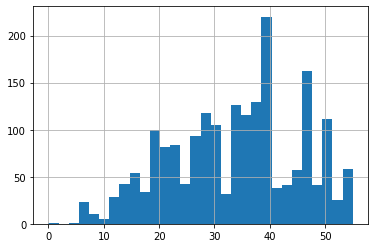

In [83]:
df['travel_min_to_CBD'].hist(bins=30)

Similarly, looking at the histogram we can say that `distance_to_sc` data is not normally distributed. Its a little skewed towards the right.

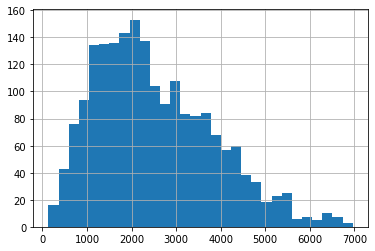

In [84]:
df['distance_to_sc'].hist(bins=30)

`distance_to_hospital` data is skewed towards the right, as can be observed from the histogram below

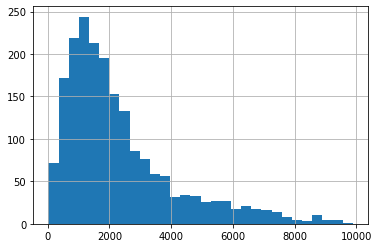

In [85]:
df['distance_to_hospital'].hist(bins=30)

`price` data is skewed towards the right, as can be observed from the histogram below.

In [86]:
#df['price'].hist(bins=30)

## Finding the most suitable transformation

## Log transformation

As we had observed from the histograms above, the data for `distance_to_hospital`, `distance_to_sc` and `price` are right skewed. So, Log transformation is a good option to penalize the large values which can help reduce the right skewness.

In [87]:
df['log(distance_to_sc)'] = None
df['log(price)'] = None
df['log(distance_to_hospital)'] = None
df['log(travel_min_to_CBD)'] = None
i = 0

for row in df.iterrows():
    df['log(distance_to_sc)'].at[i] = math.log(df["distance_to_sc"][i])
    df['log(price)'].at[i] = math.log(float(df["price"][i]))
    df['log(distance_to_hospital)'].at[i] = math.log(df["distance_to_hospital"][i])
    df['log(travel_min_to_CBD)'].at[i] = math.log(df["travel_min_to_CBD"][i]+0.00001) ## in case of 0 travel time
    i += 1

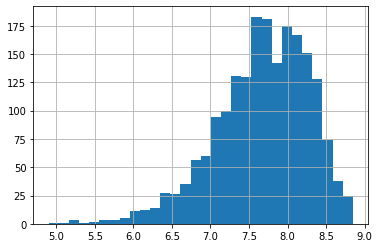

In [88]:
df['log(distance_to_sc)'].hist(bins=30)

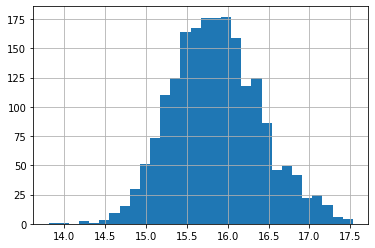

In [89]:
df['log(price)'].hist(bins=30)

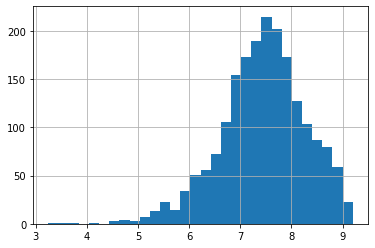

In [90]:
df['log(distance_to_hospital)'].hist(bins=30)

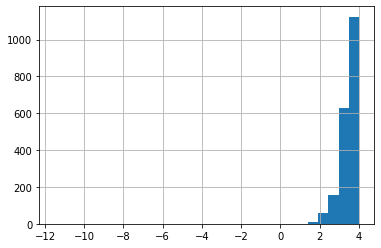

In [91]:
df['log(travel_min_to_CBD)'].hist(bins=30)

Looking at the above 4 histograms, we can see that only the histogram of `price` has improved after the log transformation and the plot looks more normaly distributed. This makes log transformation suitable for price column. 

## Square root transformation

Another suitable transformation for helping reduce the right skewness of data is square root transformation. Similar to log transformation it penalize the large values which can help reduce the right skewness of `distance_to_hospital`, `distance_to_sc` and `price`.

In [92]:
df['sqrt(distance_to_sc)'] = None
df['sqrt(price)'] = None
df['sqrt(distance_to_hospital)'] = None
df['sqrt(travel_min_to_CBD)'] = None
i = 0

for row in df.iterrows():
    df['sqrt(distance_to_sc)'].at[i] = math.sqrt(df["distance_to_sc"][i])
    df['sqrt(price)'].at[i] = math.sqrt(df["price"][i])
    df['sqrt(distance_to_hospital)'].at[i] = math.sqrt(df["distance_to_hospital"][i])
    df['sqrt(travel_min_to_CBD)'].at[i] = math.sqrt(df["travel_min_to_CBD"][i]+0.00001) # for 0 value
    i += 1

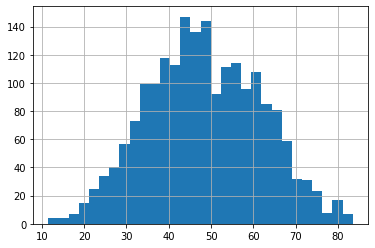

In [93]:
df['sqrt(distance_to_sc)'].hist(bins=30)

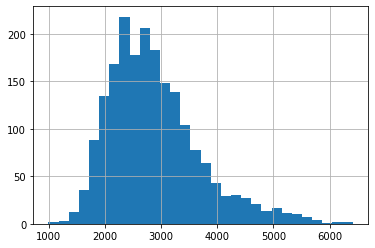

In [94]:
df['sqrt(price)'].hist(bins=30)

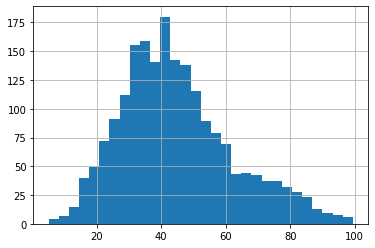

In [95]:
df['sqrt(distance_to_hospital)'].hist(bins=30)

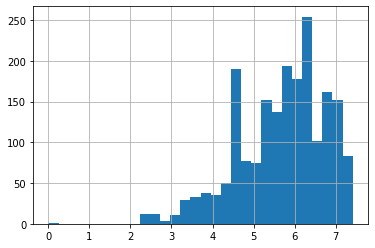

In [96]:
df['sqrt(travel_min_to_CBD)'].hist(bins=30)

Looking at the above 4 histograms, we can see that the histogram of `distance_to_sc` and `distance_to_hospital` has improved after the square root transformation and the plot looks normally distributed. This makes square root transformation suitable for `distance_to_sc` and `distance_to_hospital` column. 

## Power transformation

The data of `travel_min_to_CBD` is left skewed as we have seen from the histogram before. For this the data on the left needs to be increased. So for this, we apply power transformation to reduce the left skewness of `travel_min_to_CBD`.

A power of 1.23 gives a better distributed data for `travel_min_to_CBD`.

In [97]:
df['power(travel_min_to_CBD)'] = None
i = 0

for row in df.iterrows():
    df['power(travel_min_to_CBD)'].at[i] = df["travel_min_to_CBD"][i]**(1.23)
    
    i += 1

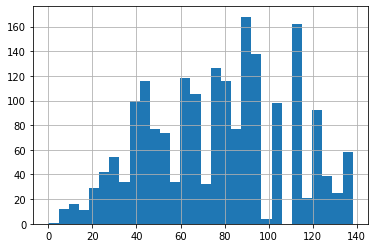

In [98]:
df['power(travel_min_to_CBD)'].hist(bins=30)

## Scaling of data

After we find the suitable transformations for each of the column, we scale the data to remove the different scales of each of the columns.

This helps in better interpretting the Linear model and the importance of each of the column on the model.

In [99]:
# applying the z score transformation on the transformed data
std_scale = preprocessing.StandardScaler().fit(df[['power(travel_min_to_CBD)', 'sqrt(distance_to_sc)','sqrt(distance_to_hospital)','log(price)']])
df_std = std_scale.transform(df[['power(travel_min_to_CBD)', 'sqrt(distance_to_sc)','sqrt(distance_to_hospital)','log(price)']]) # an array not a df

In [100]:
travel_min_to_CBD = []
distance_to_sc = []
distance_to_hospital = []
price = []

for x in df_std:
    travel_min_to_CBD.append(x[0])
    distance_to_sc.append(x[1])
    distance_to_hospital.append(x[2])
    price.append(x[3])

## Final plot after scaling

After applying square root transformation to `distance_to_sc`, `distance_to_hospital` and log transformation to `price` and power transformation to `travel_min_to_CBD`, we plot the final histograms of the scaled values.

We can observe that the data is better and looks more normal than before after the transformations.

(array([  1.,   1.,   0.,   2.,   1.,   3.,   9.,  15.,  30.,  51.,  73.,
        110., 125., 164., 167., 176., 176., 177., 159., 118., 125.,  86.,
         46.,  49.,  42.,  22.,  25.,  16.,   6.,   4.]),
 array([-3.78835356, -3.5592637 , -3.33017384, -3.10108398, -2.87199412,
        -2.64290427, -2.41381441, -2.18472455, -1.95563469, -1.72654483,
        -1.49745497, -1.26836511, -1.03927525, -0.81018539, -0.58109553,
        -0.35200567, -0.12291581,  0.10617405,  0.33526391,  0.56435377,
         0.79344363,  1.02253349,  1.25162335,  1.48071321,  1.70980307,
         1.93889293,  2.16798279,  2.39707265,  2.62616251,  2.85525237,
         3.08434223]),
 <a list of 30 Patch objects>)

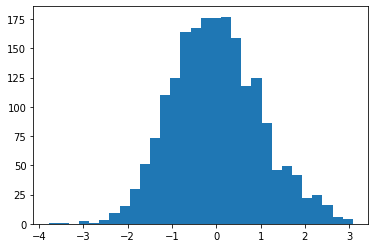

In [101]:
plt.hist(price, bins=30)

(array([  1.,  12.,  16.,  11.,  29.,  42.,  54.,  34., 100., 116.,  77.,
         74.,  34., 118., 105.,  32., 126., 116.,  77., 168., 138.,   4.,
         98.,   0., 162.,  21.,  92.,  39.,  25.,  58.]),
 array([-2.45127571, -2.30383314, -2.15639057, -2.008948  , -1.86150543,
        -1.71406287, -1.5666203 , -1.41917773, -1.27173516, -1.12429259,
        -0.97685002, -0.82940745, -0.68196489, -0.53452232, -0.38707975,
        -0.23963718, -0.09219461,  0.05524796,  0.20269052,  0.35013309,
         0.49757566,  0.64501823,  0.7924608 ,  0.93990337,  1.08734593,
         1.2347885 ,  1.38223107,  1.52967364,  1.67711621,  1.82455878,
         1.97200135]),
 <a list of 30 Patch objects>)

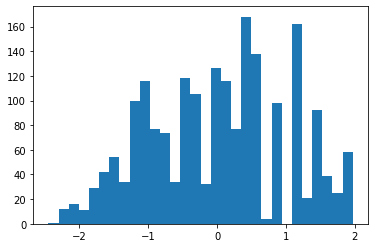

In [102]:
plt.hist(travel_min_to_CBD, bins=30)

(array([  4.,   4.,   7.,  15.,  25.,  34.,  40.,  57.,  73.,  99.,  99.,
        118., 113., 147., 136., 144.,  92., 111., 114.,  96., 108.,  85.,
         81.,  59.,  32.,  31.,  23.,   8.,  17.,   7.]),
 array([-2.74853724, -2.56968662, -2.39083599, -2.21198536, -2.03313474,
        -1.85428411, -1.67543348, -1.49658286, -1.31773223, -1.13888161,
        -0.96003098, -0.78118035, -0.60232973, -0.4234791 , -0.24462848,
        -0.06577785,  0.11307278,  0.2919234 ,  0.47077403,  0.64962466,
         0.82847528,  1.00732591,  1.18617653,  1.36502716,  1.54387779,
         1.72272841,  1.90157904,  2.08042966,  2.25928029,  2.43813092,
         2.61698154]),
 <a list of 30 Patch objects>)

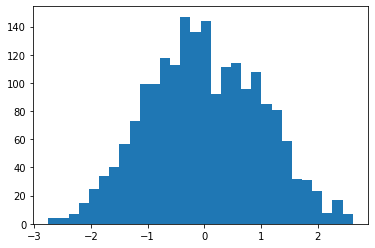

In [103]:
plt.hist(distance_to_sc, bins=30)

(array([  4.,   7.,  15.,  40.,  49.,  72.,  91., 112., 155., 159., 141.,
        180., 142., 138., 115.,  89.,  79.,  69.,  43.,  44.,  42.,  37.,
         37.,  32.,  28.,  23.,  13.,   9.,   8.,   6.]),
 array([-2.2673219 , -2.08774618, -1.90817046, -1.72859474, -1.54901902,
        -1.3694433 , -1.18986758, -1.01029186, -0.83071614, -0.65114042,
        -0.4715647 , -0.29198898, -0.11241326,  0.06716246,  0.24673818,
         0.4263139 ,  0.60588962,  0.78546534,  0.96504106,  1.14461678,
         1.3241925 ,  1.50376822,  1.68334394,  1.86291966,  2.04249538,
         2.2220711 ,  2.40164682,  2.58122254,  2.76079826,  2.94037398,
         3.1199497 ]),
 <a list of 30 Patch objects>)

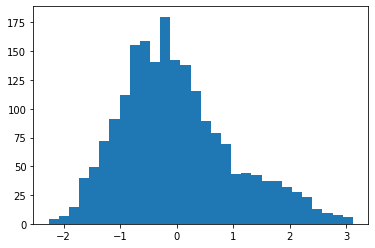

In [104]:
plt.hist(distance_to_hospital, bins=30)

# Summary
This assessment helps to build up the knowledge of Data Integration and reshaping. It imparts the knowledge of different transformations and rescaling techniques that are helpful in preparing data for machine learning models. The main objective achieved from this assessment are as follows:

- **Data Integration** - Reading different format of data and merging it to get the final dataframe for machine learning model.

- **Data Reshaping and scaling** - Data rescaling is useful for making the features independent of thier scales. This increased the readibility of data and the machine learning models.  

- **Manipulating Python Data structures and Pandas DataFrames**: For successful completion of this task knowledge of manipulating and operating on Dataframes was fundamental. The main functions used for data frame manipulation were `apply`, `zip`, `filter`, `dropna`, `isna`, `notna`, `replace`, `unique` etc. 

- **Visualizing Data**: Using `matplotlib` to plot the histograms of various columns to check for normality.

- **Formulating Regular Expressions** : Developing Regular expression to capture the latitude and longitude.

- **Using Date module**: To help validate the order date, the python `date` module was helpful. 

- **Export CSV files** : Using the pandas `to_csv` function, it was possible to export the rectified Dataframe to CSV files.

# References

codecs — Codec registry and base classes — Python 3.9.0 documentation. (2020). Retrieved 18 November 2020, from https://docs.python.org/3/library/codecs.html

Tabula: Extract Tables from PDFs. (2020). Retrieved 18 November 2020, from https://tabula.technology/

xmltodict. (2020). Retrieved 18 November 2020, from https://pypi.org/project/xmltodict/

Reference  |  Static Transit  |  Google Developers. (2020). Retrieved 18 November 2020, from https://developers.google.com/transit/gtfs/reference#tripstxt

Datasets. (2020). Retrieved 18 November 2020, from https://www.ptv.vic.gov.au/footer/data-and-reporting/datasets/

Distance on a sphere: The Haversine Formula. (2020). Retrieved 18 November 2020, from https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula